In [2]:
# pip installs

In [3]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn import Transformer

from sklearn.model_selection import train_test_split
import statistics
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from zipfile import ZipFile

from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from transformers import AutoTokenizer, AutoModelForMaskedLM

import requests
import os
import json

from torch.utils.data import Dataset, DataLoader, random_split
import random

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Define seeds

In [4]:
# define seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Data preprocessing

### here we need to load the data and extract only data with vowels punctuations

In [5]:
# path to the jason file for the dataset
data_json_path = 'data/books.json'

# Root directory where the downloaded files will be saved
texts_path = 'data/texts'


# Create the directory if it does not exist
if not os.path.exists(texts_path):
    os.makedirs(texts_path)


# Load the json dataset
with open(data_json_path, 'r', encoding='utf-8') as f:
    jason_data = json.load(f)

# download the files and save them in a folder

#### remove\add the comment as needed

In [6]:
# # Loop through the json dataset and download the files
# for entry in tqdm(jason_data):
#     try:
#         # Download the Nikud Meteg file
#         if entry['fileName'] + '__nikud_meteg' in os.listdir(texts_path):
#             continue
#         nikud_meteg_url = entry['nikudMetegFileURL']
#         nikud_meteg_local_path = os.path.join(texts_path, entry['fileName'] + '__nikud_meteg.zip')
#         nikud_meteg_response = requests.get(nikud_meteg_url)
#         with open(nikud_meteg_local_path, 'wb') as f:
#             f.write(nikud_meteg_response.content)

#             # Unzip the Nikud Meteg file
#             with ZipFile(nikud_meteg_local_path, 'r') as zipObj:
#                 zipObj.extractall(os.path.join(texts_path, entry['fileName'] + '__nikud_meteg'))
#     except Exception as e:
#         print(f"Error reading file {entry['fileName']}: {e}")
#         continue


# # iterate through the texts folder and delete the zip folders
# for file in tqdm(os.listdir(texts_path)):
#     if file.endswith(".zip"):
#         os.remove(os.path.join(texts_path, file))

# Author files

### Create a dictionary whose keys are authors and values are a list containing all it's files

In [7]:
# Define a method to create the author files dictionary
def create_author_files_dict(author_files):
    """
    This function creates a dictionary of author files with a list of their corresponding texts.
    """
    author_files_dict = {}
    for file in author_files:
        author_files_dict[file] = []
        for text_file_name in os.listdir(os.path.join(texts_path, file)):
            if text_file_name.endswith('.txt'):
                author_files_dict[file].append(text_file_name)
    return author_files_dict

author_files = os.listdir(texts_path)
author_files_dict = create_author_files_dict(author_files)

# Functions to clean the data

In [8]:
# Nikud unicode range (https://en.wikipedia.org/wiki/Unicode_and_HTML_for_the_Hebrew_alphabet)


#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}

# Read a txt file from the author files dictionary
def read_txt_file(file_path):
    """
    This function reads a txt file and returns the text as a string.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

def remove_nikud(string):
    """Removes the nikud from the given string."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    return nikud.sub("", string)

def get_nikud(word):
    """Returns the nikud from the given word."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    current_nikud = ''
    nikud_arr = []
    for i in range(len(word)):
        if i == 0:
            continue
        if nikud.match(word[i]):
            current_nikud += word[i]
        else:
            nikud_arr.append(current_nikud)
            current_nikud = ''
    nikud_arr.append(current_nikud)
    return nikud_arr

def add_nikud(word, nikud):
    """Adds the nikud to the given word."""
    new_word = ''
    for i in range(len(word)):
        new_word += word[i] + nikud[i]
    return new_word

def add_nikud_to_text(text, nikud):
    """Adds the nikud to the given text."""
    new_text = ''
    for word in text.split(' '):
        new_text += add_nikud(word, nikud) + ' '
    return new_text

def remove_first_char_if_nikud(word):
    """Removes the first char of the word if it is nikud."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    if nikud.match(word[0]):
        return word[1:]
    return word

def get_words_indices_from_text(text):
    """Returns the indices of the words in the given text."""
    text_words = text.split()
    text_words_lengths = list(map(len, text_words))
    text_words_indices = [(sum(text_words_lengths[:i]), sum(text_words_lengths[:i+1])-1) for i in range(len(text_words_lengths))]
    return text_words_indices

### Test nikud functions

In [9]:
# test the functions for adding and removing nikud
text = read_txt_file(os.path.join(texts_path, 'afikeiyam1__nikud_meteg', 'afikeiyam1-002__nikud_meteg.txt'))
# take just the first 100 characters
text = text[:100]
# remove extra spaces
text = re.sub(' +', ' ', text)
# trim text
text = text.strip()
# text_no_nikud = remove_nikud(text)
# text_nikud = get_nikud(text)
# text_with_nikud = add_nikud_to_text(text_no_nikud, text_nikud)

sentence_words = text.split()
print(f'sentence_words: {sentence_words} len: {len(sentence_words)}')
# remove the nikud from the sentence
sentence_without_nikud = remove_nikud(text)
sentence_words_without_nikud = sentence_without_nikud.split()
# get the nikud from the sentence
nikud = list(map(get_nikud, sentence_words))
print(f'nikud: {nikud} len: {len(nikud)}')
for i in range(len(sentence_words)):
    # print(f'Original word: {sentence_words[i]}')
    # print(f'Nikud: {nikud[i]}')
    # print(f'Word with nikud: {add_nikud(sentence_words_without_nikud[i], nikud[i])}')
    print(f'Original word {"==" if sentence_words[i] == add_nikud(sentence_words_without_nikud[i], nikud[i]) else "!="} word with nikud')

# sentence_with_nikud = []
# for i, word in enumerate(sentence_words):
#     sentence_with_nikud.append(add_nikud_to_text(word, nikud[i]))
# print(' '.join(sentence_with_nikud))

# print("original text:\n", text)
# print("text with added nikud:\n", text_with_nikud)
# print("text without nikud:\n", text_no_nikud)
# print("nikud array:\n", text_nikud)
# print("original is equal to text with added nikud:", text == text_with_nikud)

sentence_words: ['פֶּתַח', 'דָּבָר', 'יִתְבָּרֵךְ', 'הַבּוֹרֵא', 'וְיִשְׁתַּבַּח', 'הַיּוֹצֵר', 'אֲשֶׁר', 'מֵעוּדַי', 'גָּבַר', 'עָלַי', 'חַסְדּוֹ'] len: 11
nikud: [['ֶּ', 'ַ', ''], ['ָּ', 'ָ', ''], ['ִ', 'ְ', 'ָּ', 'ֵ', 'ְ'], ['ַ', 'ּ', 'ֹ', 'ֵ', ''], ['ְ', 'ִ', 'ְׁ', 'ַּ', 'ַּ', ''], ['ַ', 'ּ', 'ֹ', 'ֵ', ''], ['ֲ', 'ֶׁ', ''], ['ֵ', '', 'ּ', 'ַ', ''], ['ָּ', 'ַ', ''], ['ָ', 'ַ', ''], ['ַ', 'ְ', 'ּ', 'ֹ']] len: 11
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud


## Create a unified csv of all sentences

In [10]:
import csv

#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}
if 'full_data_without_puncts.csv' not in os.listdir('data'):
    columns = ['text_with_nikud', 'text_without_nikud', 'nikud', 'author', 'file_name', 'sentence_num']
    with open('data/full_data_without_puncts.csv', 'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(columns)
        for author in tqdm(author_files_dict):
            for file in author_files_dict[author]:
                text = read_txt_file(os.path.join(texts_path, author, file))
                sentences = re.split(r'\n|\.', text)
                for i, sentence in enumerate(sentences):
                    sentence = re.sub('\'|\"|\(|\)', '', sentence)
                    # Remove Dagesh, Shin Dot, Sin Dot using nikud_dict_inv
                    sentence = re.sub(nikud_dict_inv['Dagesh'], '', sentence)
                    sentence = re.sub(nikud_dict_inv['Shin Dot'], '', sentence)
                    sentence = re.sub(nikud_dict_inv['Sin Dot'], '', sentence)
                    # Keep only the nikud and hebrew letters and spaces
                    sentence = re.sub(r'[^א-ת' + ''.join(nikud_dict.keys()) + '\s]', '', sentence)
                    # remove multiple spaces
                    sentence = re.sub(r'\s+', ' ', sentence)
                    sentence = sentence.strip()
                    if sentence == '':
                        continue
                    # split the sentence into words
                    sentence_words = sentence.split()
                    # remove the nikud from the sentence
                    sentence_without_nikud = remove_nikud(sentence)
                    # make sure first char is not in [\u0591-\u05C7]
                    sentence_words = list(map(remove_first_char_if_nikud, sentence_words))
                    sentence_words = [word for word in sentence_words if word != '']
                    # get the nikud from the sentence
                    nikud = list(map(get_nikud, sentence_words))
                
                    flag = True
                    no_nikud_words = sentence_without_nikud.split()
                    for j in range(len(no_nikud_words)):
                        if sentence_words[j] != add_nikud(no_nikud_words[j], nikud[j]):
                            test_word = sentence_words[j]
                            flag = False
                            print('No match')
                                
                    # add the sentence to the dataframe
                    writer.writerow([sentence, sentence_without_nikud, nikud, author, file, i])

#### Load the data from the csv and remove sentences with more than 100 chars (without spaces) and save as json

In [11]:
# #read only first 100000 rows of the CSV, we will use this for now
# data_df = pd.read_csv('data/full_data_without_puncts.csv', nrows=200000, converters={'nikud': eval})
# print(data_df.head())

# # keep only rows s.t the length of the text (without spaces) is at most 100
# data_df = data_df[data_df['text_without_nikud'].str.replace(' ', '').str.len() <= 100]

# # save the dataframe to a json file
# data_df.to_json('data/full_data_without_puncts.json', orient='records', lines=True)

##### read the json short data

In [12]:
# read the json file
data_df = pd.read_json('data/full_data_without_puncts.json', orient='records', lines=True, nrows=55000)
print(data_df.shape)

(55000, 6)


In [13]:
# DELETE this block, only for debugging make the data smaller (randomly select 5000 rows)
data_df = data_df.sample(n=5000, random_state=1)
print(data_df.shape)

(5000, 6)


In [14]:
""" block explanation
# This block loops through each row in the data_df dataframe, reconstructs the original sentence with nikud, and compares it to the original sentence.
# If the reconstructed sentence is not the same as the original text, it prints debugging information and checks character by character to find where the two strings differ.
"""


# Loop through each row in the data_df dataframe
for i in range(len(data_df)):
    
    # Get the original text, processed text, and nikud for the current row
    original_text = data_df.iloc[i]['text_with_nikud']
    processed_text = data_df.iloc[i]['text_without_nikud'].split()
    nikud = data_df.iloc[i]['nikud']
    
    # Initialize an empty string to hold the reconstructed sentence
    sentence = ''
    
    # Loop through each word in the processed text and add the corresponding nikud
    for j in range(len(processed_text)):
        sentence += add_nikud(processed_text[j], nikud[j]) + ' '
    
    # Remove the last space from the sentence
    sentence = sentence[:-1]
    
    # If the reconstructed sentence is not the same as the original text, print some debugging information
    if original_text.strip(' ') != sentence:
        print('Original text:\n', original_text.strip(' '))
        print('Original text length: ', len(original_text.strip(' ')))
        print('Processed text:\n', sentence)
        print('Processed text length: ', len(sentence))
        
        # Check character by character to find where the two strings differ
        for k in range(len(original_text.strip(' '))):
            if original_text.strip(' ')[k] != sentence[k]:
                print('Character: ', original_text.strip(' ')[k])
                print('Character: ', sentence[k])
                print('Index: ', k)
                break
        
        print('-----------------------------------')
        break


#### Define dictionary label_to_id and id_to_label


In [15]:
label_to_id = {'<no_nikud>': 0}
id_to_label = {0: '<no_nikud>'}
for label_list in tqdm(data_df['nikud']):
    # flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_to_id:
            label_to_id[label] = len(label_to_id)
            id_to_label[len(id_to_label)] = label

print(label_to_id)



100%|██████████| 5000/5000 [00:00<00:00, 111290.17it/s]

{'<no_nikud>': 0, 'ְ': 1, 'ִ': 2, 'ֵ': 3, 'ֶ': 4, 'ֹ': 5, 'ֽ': 6, 'ָ': 7, 'ֲ': 8, 'ַ': 9, 'ֻ': 10, 'ֱ': 11, 'ׇ': 12, 'ֳ': 13, 'ַָ': 14, 'ִַ': 15}


#### count labels for label_weights

100%|██████████| 5000/5000 [00:00<00:00, 73838.18it/s]


{'ְ': 25929, 'ִ': 16984, 'ֵ': 10315, '<no_nikud>': 91941, 'ֶ': 8265, 'ֹ': 9664, 'ֽ': 5095, 'ָ': 23296, 'ֲ': 2770, 'ַ': 18470, 'ֻ': 1059, 'ֱ': 353, 'ׇ': 490, 'ֳ': 49, 'ַָ': 1, 'ִַ': 1}
[('<no_nikud>', 91941), ('ְ', 25929), ('ָ', 23296), ('ַ', 18470), ('ִ', 16984), ('ֵ', 10315), ('ֹ', 9664), ('ֶ', 8265), ('ֽ', 5095), ('ֲ', 2770), ('ֻ', 1059), ('ׇ', 490), ('ֱ', 353), ('ֳ', 49), ('ַָ', 1), ('ִַ', 1)]


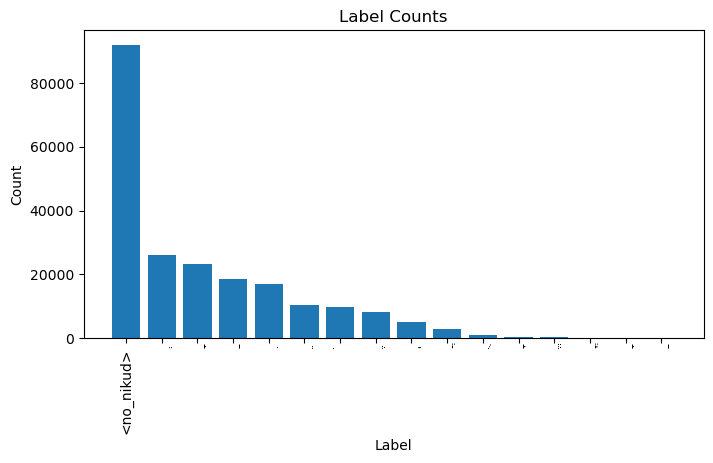

{'ְ': 0.06523157208088715, 'ִ': 0.06523157208088715, 'ֵ': 0.06523157208088715, '<no_nikud>': 0.02152641878669276, 'ֶ': 0.06523157208088715, 'ֹ': 0.06523157208088715, 'ֽ': 0.06523157208088715, 'ָ': 0.06523157208088715, 'ֲ': 0.06523157208088715, 'ַ': 0.06523157208088715, 'ֻ': 0.06523157208088715, 'ֱ': 0.06523157208088715, 'ׇ': 0.06523157208088715, 'ֳ': 0.06523157208088715, 'ַָ': 0.06523157208088715, 'ִַ': 0.06523157208088715}
label name = Sheva
label name = Hiriq
label name = Tseri
f label name = <no_nikud>
label name = Segol
label name = Holam
label name = Siluk
label name = Qamats
label name = Hataf Patah
label name = Patah
label name = Qubuts
label name = Hataf Segol
label name = Point Meteg
label name = Hataf Qamats
label name =  Qamats Patah
label name =  Hiriq Patah


In [16]:
# Count the number of each label
label_count = {}
for label_list in tqdm(data_df['nikud']):
    # Flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1

print(label_count)

# Plot counts of each label (sorted)
sorted_labels = sorted(label_count.items(), key=lambda x: x[1], reverse=True)
print(sorted_labels)
plt.figure(figsize=(8, 4))
plt.xticks(rotation=90)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.bar([x[0] for x in sorted_labels], [x[1] for x in sorted_labels])
plt.show()

# Define the label weights
label_weights = {}
for label in label_count:
    if label == "<no_nikud>":
        label_weights[label] = 0.33
    else:
        label_weights[label] = 1

# Normalize the weights
sum_weights = sum(label_weights.values())
for label in label_weights:
    label_weights[label] /= sum_weights

def set_no_nikud_weight(weight=0.33):
    label_weights = {}
    for label in label_count:
        if label == "<no_nikud>":
            label_weights[label] = weight
        else:
            label_weights[label] = 1
    sum_weights = sum(label_weights.values())
    for label in label_weights:
        label_weights[label] /= sum_weights
    # sort labels by label_to_id
    label_weights = {k: v for k, v in sorted(label_weights.items(), key=lambda item: label_to_id[item[0]])}
    return label_weights
        

print(label_weights)

for label in label_weights.keys():
    if label == "<no_nikud>":
        print(f'f label name = {label}')
    elif len(label) == 1:
        print(f'label name = {nikud_dict[label]}')
    else:
        label_name = ""
        for char in label:
            label_name += " " + nikud_dict[char]
        print(f'label name = {label_name}')
    

### EDA - DataAnalysis on short_df

In [17]:
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

class DataAnalysis:
    def __init__(self, data_df):
        self.data_df = data_df.copy()
        
    def author_distribution(self):
        # Distribution of authors
        author_distribution = self.data_df['author'].value_counts()

        # Bar plot of the distribution of the top 20 authors
        plt.figure(figsize=(10, 6))
        author_distribution[:20].plot(kind='bar')
        plt.xlabel('Author')
        plt.ylabel('Frequency')
        plt.title('Top 20 Authors')
        plt.xticks(rotation=90)
        plt.show()
        
    def file_distribution(self):
        # Distribution of files
        file_distribution = self.data_df['file_name'].value_counts()

        # Bar plot of the distribution of the top 20 files
        plt.figure(figsize=(10, 6))
        file_distribution[:20].plot(kind='bar')
        plt.xlabel('File')
        plt.ylabel('Frequency')
        plt.title('Top 20 Files')
        plt.xticks(rotation=90)
        plt.show()
        
    def sentence_length_distribution(self):
        # Create a new column for sentence length
        self.data_df['sentence_length'] = self.data_df['text_without_nikud'].str.split().str.len()

        # Get the distribution of sentence lengths
        sentence_length_distribution = self.data_df['sentence_length'].value_counts().sort_index()

        # Histogram of the distribution of sentence lengths
        plt.figure(figsize=(10, 6))
        plt.hist(self.data_df['sentence_length'], bins=50, alpha=0.5)
        plt.xlabel('Sentence Length')
        plt.ylabel('Frequency')
        plt.title('Distribution of Sentence Lengths')
        plt.show()
        
    def common_words(self):
        # Tokenize the sentences
        tokenized_sentences = self.data_df['text_without_nikud'].str.split()

        # Flatten the list of tokens and count the frequency of each token
        word_counts = Counter(chain.from_iterable(tokenized_sentences))

        # Get the 20 most common words
        common_words = word_counts.most_common(20)

        # Bar plot of the frequency of the 20 most common words
        plt.figure(figsize=(10, 6))
        words, counts = zip(*common_words)
        plt.bar(words, counts)
        plt.xlabel('Word')
        plt.ylabel('Frequency')
        plt.title('20 Most Common Words')
        plt.xticks(rotation=90)
        plt.show()
        
    def common_nikud(self):
        # Flatten the list of Nikud and count the frequency of each Nikud
        nikud_counts = Counter(chain.from_iterable(chain.from_iterable(self.data_df['nikud'])))

        # Get the 20 most common Nikud
        common_nikud = nikud_counts.most_common(20)

        # Bar plot of the frequency of the 20 most common Nikud
        plt.figure(figsize=(10, 6))
        nikud, counts = zip(*common_nikud)
        plt.bar(nikud, counts)
        plt.xlabel('Nikud')
        plt.ylabel('Frequency')
        plt.title('20 Most Common Nikud')
        plt.xticks(rotation=90)
        plt.show()

# #instantiate the class and call the methods
# data_analysis = DataAnalysis(data_df)
# data_analysis.author_distribution()
# data_analysis.file_distribution()
# data_analysis.sentence_length_distribution()
# data_analysis.common_words()
# data_analysis.common_nikud()


#### download tokenizer and model
(alephbert-base, with vocab of words with len <= 1)

In [18]:
model_path = 'C:\\Users\\baruc\\PycharmProjects\\pythonProject\\Punctuation_Restoration\\AlephBERT-main\\AlephBERT-main\\models\\alephbert-base'
alephbert_tokenizer = AutoTokenizer.from_pretrained(model_path)
alephbert_model = AutoModelForMaskedLM.from_pretrained("onlplab/alephbert-base")

In [19]:
# test the tokenization and detokenization
test = "בדיקה של הדבר הזה"
tokenized = alephbert_tokenizer.tokenize(test)
encoded = alephbert_tokenizer.encode(test)
decoded = alephbert_tokenizer.decode(encoded)
print(test)
print("tokenized: ", tokenized)
print("encoded: ", encoded)
print("decoded: ", decoded)

בדיקה של הדבר הזה
tokenized:  ['ב', '##ד', '##י', '##ק', '##ה', 'ש', '##ל', 'ה', '##ד', '##ב', '##ר', 'ה', '##ז', '##ה']
encoded:  [2, 177, 1039, 1008, 1013, 1016, 201, 1009, 180, 1039, 1037, 1014, 180, 1075, 1016, 3]
decoded:  [CLS] בדיקה של הדבר הזה [SEP]


In [20]:
data_df.iloc[0]
text = data_df.iloc[0]['text_without_nikud']
nikud = data_df.iloc[0]['nikud']
for row in data_df.iterrows():
    text = row[1]['text_without_nikud']
    text_with_nikud = row[1]['text_with_nikud']
    nikud = row[1]['nikud']
    text_words = text.split()
    sentence = []
    for i in range(len(nikud)):
        sentence.append(add_nikud(text_words[i], nikud[i]))
    sentence = ' '.join(sentence)
    if sentence != text_with_nikud:
        print(sentence)
        print(text_with_nikud)
        print('------------------')

# create DataSet class

In [21]:
# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))

class PunctuationRestorationDataset(Dataset):
    def __init__(self, data_df, tokenizer, label_to_id, max_len):
        self.data = data_df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_to_id = label_to_id 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index): # TODO: need to make sure not to look at fraction of words
        text = self.data.iloc[index]['text_without_nikud']
        nikud = self.data.iloc[index]['nikud']  # list of lists of nikud

        # flatten nikud list
        nikud = [item for sublist in nikud for item in sublist]
        # replace empty strings with <no_nikud> token
        nikud = [label if label != "" else "<no_nikud>" for label in nikud]
        # replace labels with ids
        nikud = [self.label_to_id[label] for label in nikud]

        # check if nikud length is the same as text without spaces length
        if len(text.replace(" ", "")) != len(nikud):
            print("text without spaces length: ", len(text.replace(" ", "")))
            print("nikud length: ", len(nikud))
        
        # get word indices after tokenization
        word_indices = get_words_indices_from_text(text)
        # pad word_indices to be the same length as input_ids
        word_indices = word_indices + [(-1, -1)] * (self.max_len - len(word_indices))
        # convert word_indices to tensor
        word_indices = torch.tensor(word_indices, dtype=torch.long)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # pad nikud to be the same length as input_ids
        nikud = nikud + [len(label_to_id)] * (encoding['input_ids'].shape[1] - len(nikud))
        # convert to tensor
        nikud = torch.tensor(nikud, dtype=torch.long)
        
        return {
            'text': text,
            'nikud': nikud,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'word_indices': word_indices
        }


# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))
dataset = PunctuationRestorationDataset(data_df, alephbert_tokenizer, label_to_id, 100)
print("dataset length: ", len(dataset))

dataset length:  5000


In [22]:
# #iterate over dataset
for i in range(len(dataset)):
    sample = dataset[i]
    Original = data_df.iloc[i]['text_with_nikud']
    text_without_nikud = sample['text']
    nikud = sample['nikud']
    input_ids = sample['input_ids']
    attention_mask = sample['attention_mask']
    word_indices = sample['word_indices']
    
    # convert nikud_id to nikud_label
    nikud_after_id_to_label = [id_to_label[id] if id < len(id_to_label) else "<no_nikud>" for id in nikud.tolist()]
    # add nikud to text without nikud
    text_words = text_without_nikud.split()
    text_words_with_nikud = []
    for word_index, word in enumerate(text_words):
        text_words_with_nikud.append(add_nikud(word, nikud_after_id_to_label[word_indices[word_index][0]:word_indices[word_index][1]+1]))
    text_with_nikud = " ".join(text_words_with_nikud)
    text_with_nikud = text_with_nikud.replace("<no_nikud>", "")
    if text_with_nikud != Original:
        print("text_with_nikud: ", text_with_nikud)
        print("Original: ", Original)
    #print("word_indices: ", word_indices)
    # convert input_ids to tokens
    tokens = alephbert_tokenizer.convert_ids_to_tokens(input_ids)
    if i > 5:
        break
    
    # # Check that nikud alligns with tokens
    # nikud = nikud.tolist()
    # # zip tokens and nikud
    # tokens_with_nikud = list(zip(tokens, nikud))
    # # print("tokens_with_nikud: ", tokens_with_nikud)
    # for token, label in tokens_with_nikud:
    #     if token == "[PAD]" and label != len(id_to_label) or token != "[PAD]" and label == len(id_to_label):
    #         print("token: ", token)
    #         print("label: ", label)
                


#### split to train,val and test datasets and dataloaders

In [23]:
# split dataset to train, val and test
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 32

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# performe EDAs on the data

In [24]:
# EDA on train, val and test dataset
print("train dataset size: ", len(train_dataset))
print("val dataset size: ", len(val_dataset))
print("test dataset size: ", len(test_dataset))

# train dataset
print("train dataset type: ", type(train_dataset))
print("train dataset[0] type: ", type(train_dataset[0]))
print("train dataset[0] keys: ", train_dataset[0].keys())

train dataset size:  3600
val dataset size:  900
test dataset size:  500
train dataset type:  <class 'torch.utils.data.dataset.Subset'>
train dataset[0] type:  <class 'dict'>
train dataset[0] keys:  dict_keys(['text', 'nikud', 'input_ids', 'attention_mask', 'word_indices'])


# Define the two models (one with look-ahead, one without)

### train the two models

### Evaluate the models

## Full-Sentence Model

In [25]:
class FullSentenceModel(nn.Module):
    def __init__(self, char_vocab_size, num_labels, char_embedding_dim=32, word_hidden_dim=16, char_hidden_dim=512, num_layers=4):
        super(FullSentenceModel, self).__init__()
        
        self.word_hidden_dim = word_hidden_dim
        
        # Character Embedding Layer
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        
        # Word-Level BiLSTM
        self.word_bilstm = nn.LSTM(char_embedding_dim, word_hidden_dim, bidirectional=True, batch_first=True)
        
        # Character-Level LSTM
        self.char_lstm = nn.LSTM(input_size=char_embedding_dim + 2 * word_hidden_dim, hidden_size=char_hidden_dim,bidirectional=True, batch_first=True, num_layers=num_layers)
        
        # Fully Connected Layer
        self.fc = nn.Linear(2 * char_hidden_dim, num_labels)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, char_sequence, word_boundaries):
        # Apply Character Embedding
        char_embedded = self.char_embedding(char_sequence)
        
        # Process each word using the Word-Level BiLSTM
        word_embeddings_list = []
        for i in range(len(char_sequence)):
            word_embedding_for_sample = []
            for boundaries in word_boundaries[i]:
                start, end = boundaries
                if start == -1:
                    break
                word_seq = char_embedded[i, start:end+1, :]
                word_seq_output, _ = self.word_bilstm(word_seq.unsqueeze(0))
                word_embedding = torch.cat((word_seq_output[0, -1, :self.word_hidden_dim], 
                                            word_seq_output[0, 0, self.word_hidden_dim:]), dim=0)
                word_embedding_for_sample.append(word_embedding)
            word_embeddings_list.append(torch.stack(word_embedding_for_sample))
        
        # Pad the word embeddings to the same length as the input sequence
        max_length = char_embedded.size(1)
        padded_word_embeddings_list = []
        for embed in word_embeddings_list:
            padding_length = max_length - embed.size(0)
            padding = torch.zeros(padding_length, embed.size(1)).to(embed.device)
            padded_embed = torch.cat([embed, padding], dim=0)
            padded_word_embeddings_list.append(padded_embed)
        word_embeddings_tensor = torch.stack(padded_word_embeddings_list, dim=0)
        
        # Concatenate the character embeddings with the word embeddings
        char_word_embedded = torch.cat([char_embedded, word_embeddings_tensor], dim=2)
        
        # Apply Character-Level LSTM
        char_lstm_output, _ = self.char_lstm(char_word_embedded)
        
        # Apply Dropout
        char_lstm_output = self.dropout(char_lstm_output)
        
        # Apply Fully Connected Layer
        predictions = self.fc(char_lstm_output)
        
        return predictions
    



In [26]:
def train_full_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        word_indices = batch['word_indices'].to(device)
        labels = batch['nikud'].to(device)
        optimizer.zero_grad()
        predictions = model.forward(input_ids, word_indices)
        loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        attention_mask = batch['attention_mask']
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        predictions = predictions[attention_mask.view(-1) == 1]
        labels = labels[attention_mask.view(-1) == 1]
        predictions = torch.argmax(predictions, dim=1)

        # calculate accuracy
        pre = predictions.cpu().numpy()
        lab = labels.cpu().numpy()
        total_correct += np.sum(pre == lab)
        total_overall += len(pre)
        
    accuracy_avg = total_correct / total_overall
    loss_avg = total_loss / len(train_loader)
    return loss_avg, accuracy_avg

# Define evaluate method
def evaluate_full_model(model, eval_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            input_ids = batch['input_ids'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            predictions = model.forward(input_ids, word_indices)
            loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
            total_loss += loss.item()
            # total_correct += (predictions.argmax(2) == labels).sum().item()

            attention_mask = batch['attention_mask']
            predictions = predictions.view(-1, predictions.shape[-1])
            labels = labels.view(-1)
            predictions = predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            predictions = torch.argmax(predictions, dim=1)
            # calculate accuracy
            pre = predictions.cpu().numpy()
            lab = labels.cpu().numpy()
            total_correct += np.sum(pre == lab)
            total_overall += len(pre)
    accuracy_avg = total_correct / total_overall
    loss_avg = total_loss / len(train_loader)
    return loss_avg, accuracy_avg




In [27]:
# Define predict method
def predict_full_model(model, test_loader):
    """
    Predict the labels of the test set using the model.
    """
    model.eval()
    actual_labels = []
    predictions = []
    all_words = []
    for batch in tqdm(test_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            
            # get the model's predictions
            batch_predictions = model.forward(input_ids, word_indices)
            batch_predictions = batch_predictions.view(-1, batch_predictions.shape[-1])
            labels = labels.view(-1)
            word_indices = word_indices.view(-1, 2)
            
            # remove the padding tokens from the predictions
            batch_predictions = batch_predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            word_indices = word_indices[word_indices[:, 0] != -1]
            
            # get the top 2 predictions for each token
            batch_predictions = torch.topk(batch_predictions, k=2, dim=1).indices
            first_prediction = batch_predictions[:, 0]
            second_prediction = batch_predictions[:, 1]
            
            predictions.extend(first_prediction)
            actual_labels.extend(labels)
            all_words.extend(word_indices)
    all_words = [word.tolist() for word in all_words]
    all_words = list(map(lambda x: x[1]-x[0]+1, all_words))
    return actual_labels, predictions, all_words

In [28]:
# Hyperparameters
num_epochs = 3
char_vocab_size = alephbert_tokenizer.vocab_size
char_embedding_dim = 32
word_hidden_dim = 16
char_hidden_dim = 512
num_labels = len(label_to_id)

# Model, Criterion, Optimizer
full_sentence_model = FullSentenceModel(char_vocab_size, num_labels, char_embedding_dim=char_embedding_dim, word_hidden_dim=word_hidden_dim, char_hidden_dim=char_hidden_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id)).to(device)
optimizer = optim.Adam(full_sentence_model.parameters(), lr=0.001)

# History
train_full_sentence_model_loss_history = []
val_full_sentence_model_loss_history = []
train_full_sentence_model_accuracy_history = []
val_full_sentence_model_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    # train and evaluate
    train_loss, train_accuracy = train_full_model(full_sentence_model, train_loader, optimizer, criterion)
    eval_loss, eval_accuracy = evaluate_full_model(full_sentence_model, val_loader, criterion)
    # print epoch, loss, accuracy
    print(f'Epoch: {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
    print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
    print('-'*10)
    # append to history
    train_full_sentence_model_loss_history.append(train_loss)
    val_full_sentence_model_loss_history.append(eval_loss)
    train_full_sentence_model_accuracy_history.append(train_accuracy)
    val_full_sentence_model_accuracy_history.append(eval_accuracy)

100%|██████████| 29/29 [00:05<00:00,  4.85it/s]


Epoch: 1
Train Loss: 1.517 | Train Accuracy: 51.62%
Eval Loss: 0.241 | Eval Accuracy: 66.60%
----------


100%|██████████| 29/29 [00:06<00:00,  4.78it/s]


Epoch: 2
Train Loss: 0.754 | Train Accuracy: 73.45%
Eval Loss: 0.154 | Eval Accuracy: 79.57%
----------


100%|██████████| 29/29 [00:06<00:00,  4.18it/s]

Epoch: 3
Train Loss: 0.501 | Train Accuracy: 83.34%
Eval Loss: 0.111 | Eval Accuracy: 85.71%
----------


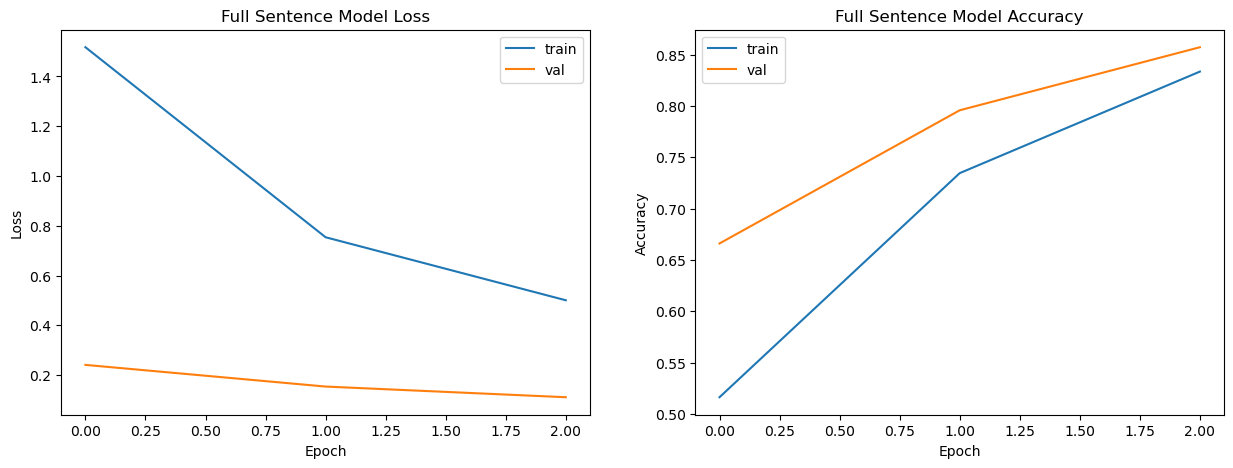

In [29]:
# plot train and val loss and accuracy

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_full_sentence_model_loss_history, label='train')
plt.plot(val_full_sentence_model_loss_history, label='val')
plt.title('Full Sentence Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_full_sentence_model_accuracy_history, label='train')
plt.plot(val_full_sentence_model_accuracy_history, label='val')
plt.title('Full Sentence Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()




#### Reading-Direction Model

In [30]:
class ReadingDirectionModel(nn.Module):
    def __init__(self, char_vocab_size, num_labels, char_embedding_dim=32, word_hidden_dim=16, char_hidden_dim=512, num_layers=4):
        super(ReadingDirectionModel, self).__init__()
        
        self.word_hidden_dim = word_hidden_dim
        
        # Character Embedding Layer
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        
        # Word-Level BiLSTM
        self.word_bilstm = nn.LSTM(char_embedding_dim, word_hidden_dim, bidirectional=True, batch_first=True)
        
        # Character-Level LSTM
        self.char_lstm = nn.LSTM(input_size=char_embedding_dim + 2 * word_hidden_dim, hidden_size=char_hidden_dim, batch_first=True, num_layers=num_layers)
        
        # Fully Connected Layer
        self.fc = nn.Linear(char_hidden_dim, num_labels)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, char_sequence, word_boundaries):
        # Apply Character Embedding
        char_embedded = self.char_embedding(char_sequence)
        
        # Process each word using the Word-Level BiLSTM
        word_embeddings_list = []
        for i in range(len(char_sequence)):
            word_embedding_for_sample = []
            for boundaries in word_boundaries[i]:
                start, end = boundaries
                if start == -1:
                    break
                word_seq = char_embedded[i, start:end+1, :]
                word_seq_output, _ = self.word_bilstm(word_seq.unsqueeze(0))
                word_embedding = torch.cat((word_seq_output[0, -1, :self.word_hidden_dim], 
                                            word_seq_output[0, 0, self.word_hidden_dim:]), dim=0)
                word_embedding_for_sample.append(word_embedding)
            word_embeddings_list.append(torch.stack(word_embedding_for_sample))
        
        # Pad the word embeddings to the same length as the input sequence
        max_length = char_embedded.size(1)
        padded_word_embeddings_list = []
        for embed in word_embeddings_list:
            padding_length = max_length - embed.size(0)
            padding = torch.zeros(padding_length, embed.size(1)).to(embed.device)
            padded_embed = torch.cat([embed, padding], dim=0)
            padded_word_embeddings_list.append(padded_embed)
        word_embeddings_tensor = torch.stack(padded_word_embeddings_list, dim=0)
        
        # Concatenate the character embeddings with the word embeddings
        char_word_embedded = torch.cat([char_embedded, word_embeddings_tensor], dim=2)
        
        # Apply Character-Level LSTM
        char_lstm_output, _ = self.char_lstm(char_word_embedded)
        
        # Apply Dropout
        char_lstm_output = self.dropout(char_lstm_output)
        
        # Apply Fully Connected Layer
        predictions = self.fc(char_lstm_output)
        
        return predictions
    



In [31]:
def train_directional_model(model, train_loader, optimizer, criterion, train_directional_model_loss_history):
    model.train()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        word_indices = batch['word_indices'].to(device)
        labels = batch['nikud'].to(device)
        optimizer.zero_grad()
        predictions = model.forward(input_ids, word_indices)
        loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_directional_model_loss_history.append(loss.item())
        
        attention_mask = batch['attention_mask']
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        predictions = predictions[attention_mask.view(-1) == 1]
        labels = labels[attention_mask.view(-1) == 1]
        predictions = torch.argmax(predictions, dim=1)

        # calculate accuracy
        pre = predictions.cpu().numpy()
        lab = labels.cpu().numpy()
        total_correct += np.sum(pre == lab)
        total_overall += len(pre)
    accuracy = total_correct / total_overall
    return total_loss / len(train_loader), accuracy

# Define evaluate method
def evaluate_directional_model(model, eval_loader, criterion, val_directional_model_loss_history):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            input_ids = batch['input_ids'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            predictions = model.forward(input_ids, word_indices)
            loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
            total_loss += loss.item()
            # total_correct += (predictions.argmax(2) == labels).sum().item()
            val_directional_model_loss_history.append(loss.item())

            attention_mask = batch['attention_mask']
            predictions = predictions.view(-1, predictions.shape[-1])
            labels = labels.view(-1)
            predictions = predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            predictions = torch.argmax(predictions, dim=1)
            # calculate accuracy
            pre = predictions.cpu().numpy()
            lab = labels.cpu().numpy()
            total_correct += np.sum(pre == lab)
            total_overall += len(pre)
    accuracy = total_correct / total_overall
    return total_loss / len(eval_loader), accuracy



In [32]:
# Define predict method
def predict_directional_model(model, test_loader):
    """
    Predict the labels of the test set using the model.
    """
    model.eval()
    actual_labels = []
    predictions = []
    all_words = []
    for batch in tqdm(test_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            
            # get the model's predictions
            batch_predictions = model.forward(input_ids, word_indices)
            batch_predictions = batch_predictions.view(-1, batch_predictions.shape[-1])
            labels = labels.view(-1)
            word_indices = word_indices.view(-1, 2)
            
            # remove the padding tokens from the predictions
            batch_predictions = batch_predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            word_indices = word_indices[word_indices[:, 0] != -1]
            
            # get the top 2 predictions for each token
            batch_predictions = torch.topk(batch_predictions, k=2, dim=1).indices
            first_prediction = batch_predictions[:, 0]
            second_prediction = batch_predictions[:, 1]
            
            predictions.extend(first_prediction)
            actual_labels.extend(labels)
            all_words.extend(word_indices)
    all_words = [word.tolist() for word in all_words]
    all_words = list(map(lambda x: x[1]-x[0]+1, all_words))
    return actual_labels, predictions, all_words

In [33]:
# Hyperparameters
char_vocab_size = alephbert_tokenizer.vocab_size
char_embedding_dim = 32
word_hidden_dim = 16
char_hidden_dim = 512
num_labels = len(label_to_id)

# Model, Criterion, Optimizer
reading_direction_model = ReadingDirectionModel(char_vocab_size, num_labels, char_embedding_dim=char_embedding_dim, word_hidden_dim=word_hidden_dim, char_hidden_dim=char_hidden_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id)).to(device)
optimizer = optim.Adam(reading_direction_model.parameters(), lr=0.001)

# Training loop
train_directional_model_loss_history = []
val_directional_model_loss_history = []
# check if model is already trained
if os.path.exists('directional_model_10_epoch.pt'): # TODO: Delete (and False) to load model
    reading_direction_model.load_state_dict(torch.load('directional_model_10_epoch.pt'))
    print('Model loaded successfully!')
    with open('directional_model_10_epoch_loss_history.pkl', 'rb') as f:
        train_directional_model_loss_history, val_directional_model_loss_history = pickle.load(f)
    print('Model loss history loaded successfully!')
else:
    for epoch in range(10):
        train_loss, train_accuracy = train_directional_model(reading_direction_model, train_loader, optimizer, criterion, train_directional_model_loss_history)
        eval_loss, eval_accuracy = evaluate_directional_model(reading_direction_model, val_loader, criterion, val_directional_model_loss_history)
        print(f'Epoch: {epoch+1}')
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
        print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
        print('-'*10)
        # plot train and eval loss
        plt.plot(train_directional_model_loss_history, label='train')
        plt.plot(val_directional_model_loss_history, label='eval')
        plt.legend()
        plt.show()

    # save directional_model_10_epoch
    torch.save(reading_direction_model.state_dict(), 'directional_model_10_epoch.pt')
    print('Model saved successfully!')
    # save directional_model_10_epoch_loss_history
    with open('directional_model_10_epoch_loss_history.pkl', 'wb') as f:
        pickle.dump([train_directional_model_loss_history, val_directional_model_loss_history], f)
    print('Model loss history saved successfully!')

Model loaded successfully!
Model loss history loaded successfully!


# Models analysis functions

In [34]:
def compute_character_accuracy(actual_labels, predictions):
    """
    Compute the character-level accuracy.
    """
    correct = sum([1 for p, a in zip(predictions, actual_labels) if p == a])
    total = len(predictions)
    return correct / total

def compute_character_accuracy_without_no_nikud(actual_labels, predictions, no_nikud_token='<no_nikud>'):
    """
    Compute the character-level accuracy without counting the no_nikud_token.
    """
    correct = sum([1 for p, a in zip(predictions, actual_labels) if p == a and a != no_nikud_token])
    #print(f'actual_labels: {actual_labels}')
    total = len([a for a in actual_labels if a != no_nikud_token])
    return correct / total


def compute_word_accuracy(actual_labels, predictions, word_lengths):
    """
    Compute the word-level accuracy.
    """
    current_index = 0
    correct_words = 0
    for word_length in word_lengths:
        word_char_predictions = predictions[current_index : current_index + word_length]
        word_labels = actual_labels[current_index : current_index + word_length]
        comparison = all([p == a for p, a in zip(word_char_predictions, word_labels)])
        if comparison:
            correct_words += 1
        current_index += word_length

    return correct_words / len(word_lengths)

def compute_word_accuracy_without_no_nikud(actual_labels, predictions, word_lengths, no_nikud_token='<no_nikud>'):
    """
    Compute the word-level accuracy without counting the no_nikud_token.
    """
    current_index = 0
    correct_words = 0
    for word_length in word_lengths:
        word_char_predictions = predictions[current_index : current_index + word_length]
        word_labels = actual_labels[current_index : current_index + word_length]
        comparison = all([p == a for p, a in zip(word_char_predictions, word_labels) if a != no_nikud_token])
        if comparison:
            correct_words += 1
        current_index += word_length

    return correct_words / len(word_lengths)

In [35]:
def plot_confusion_matrix(actuals, predictions, labels):
    """
    Plot a confusion matrix for the model's predictions.
    """
    cm = confusion_matrix(actuals, predictions, labels=labels)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    epsilon = 1e-8
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + epsilon)
    cm[np.isnan(cm)] = 0
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
    # sns.heathamap
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

def convert_labels_to_names(actuals, predictions, label_to_id):
    """
    Convert the labels to their names.
    """
    nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim'}
    labels = list(label_to_id.keys())
    label_names = {'<no_nikud>': 'No Nikud'}
    for label in labels:
        if label == '<no_nikud>':
            continue
        label_name = []
        for char in label:
            label_name.append(nikud_dict[char])
        label_names[label] = ' '.join(label_name)
    actuals = [label_names[label] for label in actuals]
    predictions = [label_names[label] for label in predictions]
    return actuals, predictions, label_names

## Analysis of Full Sentence Model

100%|██████████| 16/16 [00:03<00:00,  4.43it/s]


Character-level accuracy: 85.50%
Character-level accuracy without no-nikud: 77.99%
Word-level accuracy: 64.18%
Word-level accuracy without no-nikud: 67.68%


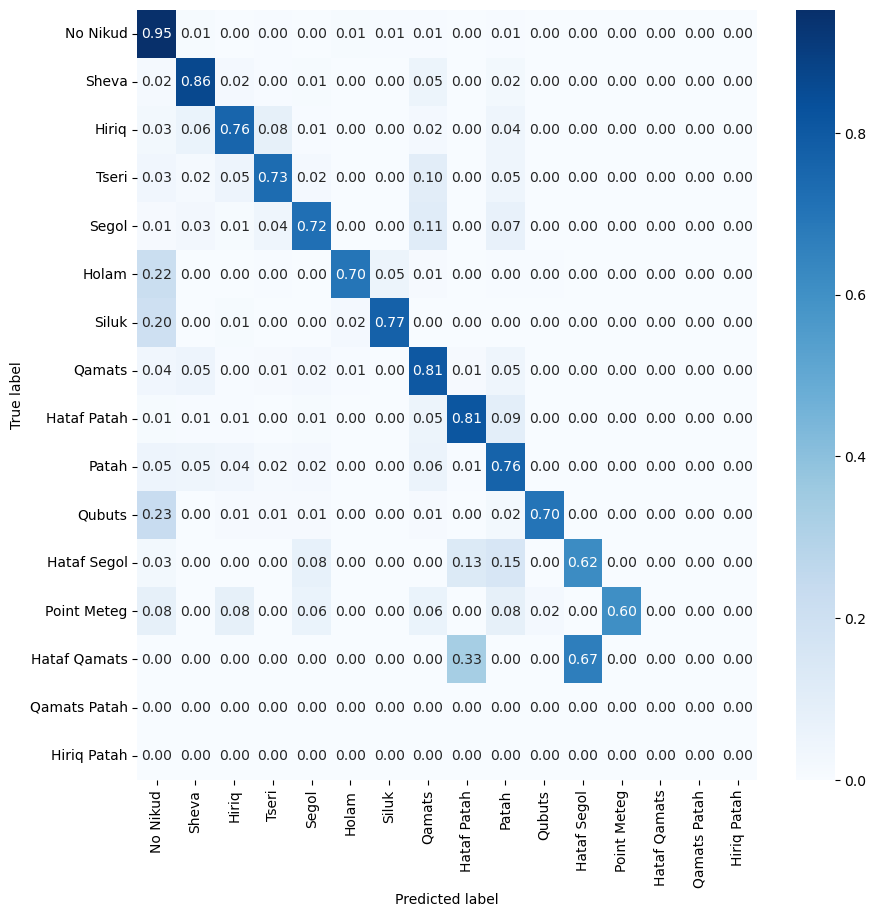

In [36]:
# get predictions for the test set
actuals, predictions, word_lengths = predict_full_model(full_sentence_model, test_loader)
# convert the actual labels and the predictions to lists
actuals = [id_to_label[label.item()] for label in actuals]
predictions = [id_to_label[label.item()] for label in predictions]
# predictions, actual_labels, all_words = predict_full_model(model, test_loader)
char_accuracy = compute_character_accuracy(actuals, predictions)
char_accuracy_without_no_nikud = compute_character_accuracy_without_no_nikud(actuals, predictions)
# word_boundaries = [batch["word_indices"] for batch in test_loader]  # Assuming this is how word boundaries are stored.
word_accuracy = compute_word_accuracy(actuals, predictions, word_lengths)
word_accuracy_without_no_nikud = compute_word_accuracy_without_no_nikud(actuals, predictions, word_lengths)

print(f"Character-level accuracy: {char_accuracy:.2%}")
print(f"Character-level accuracy without no-nikud: {char_accuracy_without_no_nikud:.2%}")
print(f"Word-level accuracy: {word_accuracy:.2%}")
print(f"Word-level accuracy without no-nikud: {word_accuracy_without_no_nikud:.2%}")
# convert the labels to names
actuals, predictions, label_names = convert_labels_to_names(actuals, predictions, label_to_id)
plot_confusion_matrix(actuals, predictions, list(label_names.values()))

## Analysis of Reading Direction Model

100%|██████████| 113/113 [00:24<00:00,  4.54it/s]


Character-level accuracy: 73.57%
Character-level accuracy without no-nikud: 62.60%
Word-level accuracy: 32.29%
Word-level accuracy without no-nikud: 42.59%


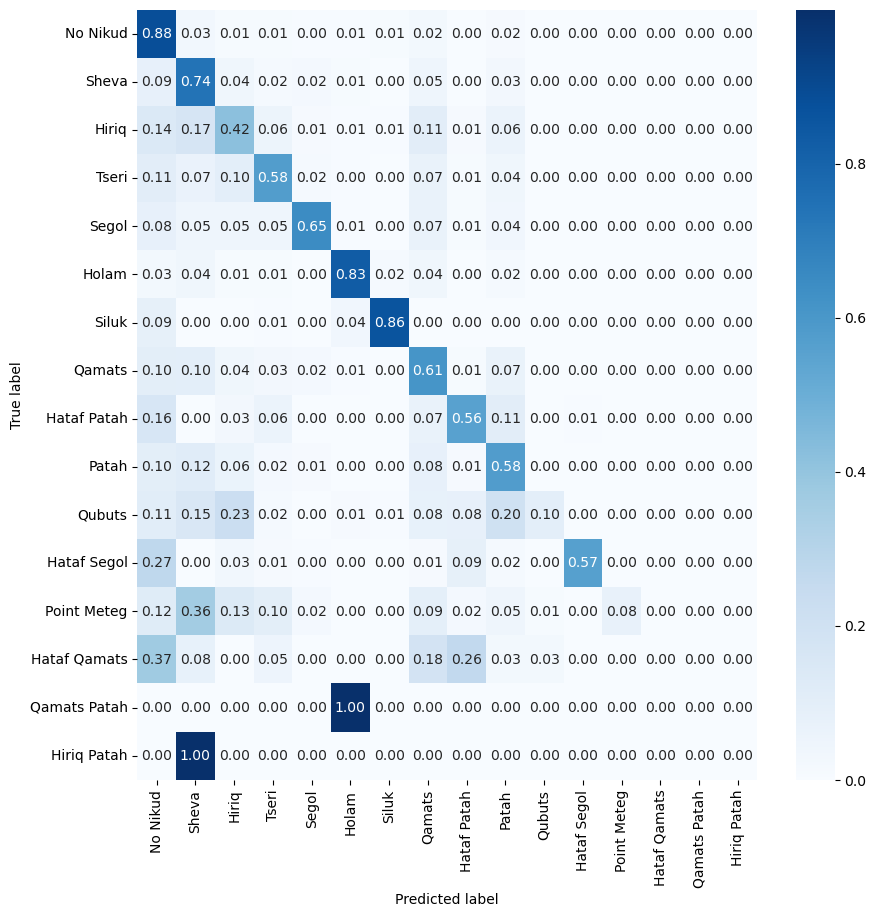

In [37]:
# get predictions for the test set
# actuals, predictions, word_lengths = predict_directional_model(reading_direction_model, test_loader)
actuals, predictions, word_lengths = predict_directional_model(reading_direction_model, train_loader)
# convert the actual labels and the predictions to lists
actuals = [id_to_label[label.item()] for label in actuals]
predictions = [id_to_label[label.item()] for label in predictions]
# predictions, actual_labels, all_words = predict_full_model(model, test_loader)
char_accuracy = compute_character_accuracy(actuals, predictions)
char_accuracy_without_no_nikud = compute_character_accuracy_without_no_nikud(actuals, predictions)
# word_boundaries = [batch["word_indices"] for batch in test_loader]  # Assuming this is how word boundaries are stored.
word_accuracy = compute_word_accuracy(actuals, predictions, word_lengths)
word_accuracy_without_no_nikud = compute_word_accuracy_without_no_nikud(actuals, predictions, word_lengths)

print(f"Character-level accuracy: {char_accuracy:.2%}")
print(f"Character-level accuracy without no-nikud: {char_accuracy_without_no_nikud:.2%}")
print(f"Word-level accuracy: {word_accuracy:.2%}")
print(f"Word-level accuracy without no-nikud: {word_accuracy_without_no_nikud:.2%}")
# convert the labels to names
actuals, predictions, label_names = convert_labels_to_names(actuals, predictions, label_to_id)
plot_confusion_matrix(actuals, predictions, list(label_names.values()))

# Define the dual model class, it will be composed of two models.
#### whenever there is a disagreement between the two models, the model will add nikud using the lookahead model

In [38]:
# # Define a class for the dual model
# class DuelModel():
#     def __init__(self, full_sentence_model, directional_model, tokenizer):
#         # Initialize the dual model with the full sentence model and the directional model
#         self.full_sentence_model = full_sentence_model
#         self.directional_model = directional_model
#         self.tokenizer = tokenizer
    
#     def predict_batch(self, batch):
#         # Set both models to evaluation mode
#         self.full_sentence_model.eval()
#         self.directional_model.eval()
#         # Initialize empty lists for the dual model predictions and the word lengths
#         dual_model_predictions = []
#         dual_model_predictions_words = []
#         # Disable gradient calculation
#         with torch.no_grad():
#             # Move the input data to the device
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             word_indices = batch['word_indices'].to(device)

#             # Get the logits from both models
#             full_sentence_logits = self.full_sentence_model.forward(input_ids, word_indices)
#             directional_logits = self.directional_model.forward(input_ids, word_indices)

#             # Get the predictions from both models
#             full_sentence_predictions = torch.argmax(full_sentence_logits, dim=2)
#             directional_predictions = torch.argmax(directional_logits, dim=2)
#             # iterate over each prediction
#             for i in range(len(full_sentence_predictions)):
#                 current_prediction = []
#                 current_prediction_words = []
#                 # remove padding from the prediction
#                 full_sentence_prediction = full_sentence_predictions[i][attention_mask[i] == 1]
#                 directional_prediction = directional_predictions[i][attention_mask[i] == 1]

#                 # for each token in the prediction, check if both models agree, if not - use the full sentence model prediction, otherwise change to 0
#                 for j in range(len(full_sentence_prediction)):
#                     if full_sentence_prediction[j] != directional_prediction[j]:
#                         current_prediction.append(full_sentence_prediction[j].item())
#                     else:
#                         current_prediction.append(0)
#                 dual_model_predictions.append(current_prediction)

#                 # Get the word lengths for the current prediction
#                 word_indices_of_current_prediction = word_indices[i][word_indices[i][:, 0] != -1]
#                 word_indices_of_current_prediction = [word.tolist() for word in word_indices_of_current_prediction]
#                 current_prediction_words = list(map(lambda x: x[1]-x[0]+1, word_indices_of_current_prediction))
#                 dual_model_predictions_words.append(current_prediction_words)

#         # Return the dual model predictions and the word lengths
#         return dual_model_predictions, dual_model_predictions_words
            

# # Create an instance of the dual model
# dual_model = DuelModel(full_sentence_model, reading_direction_model, alephbert_tokenizer)
# # Get the first batch of test_loader which doesn't change between runs
# batch = next(iter(test_loader))
# # Get the dual model predictions and the word lengths for the batch
# dual_model_predictions, dual_model_predictions_words = dual_model.predict_batch(batch)
# # Check if the prediction lengths match the word lengths
# for i, prediction in enumerate(dual_model_predictions):
#     prediction_length = len(prediction)
#     prediction_words_sum = sum(dual_model_predictions_words[i])
#     if prediction_length != prediction_words_sum:
#         print(f"error in prediction {i}")
#     else:
#         print(f"prediction {i} is correct, here is some info:")
#         print(f"prediction length: {prediction_length}")
#         print(f"prediction words sum: {prediction_words_sum}")
#         print(f"prediction: {prediction}")
#         print(f"word lengths: {dual_model_predictions_words[i]}")
#         print("")
#         # print predictions next to the original nikud, check accuracy
#         print("original nikud:")
#         og_nikud = batch['nikud'][i][batch['attention_mask'][i] == 1]
#         print(og_nikud)
#         print("prediction:")
#         pred_nikud = torch.tensor(prediction)
#         print(pred_nikud)
#         print(f"og nikud length: {len(og_nikud)}, pred nikud length: {len(pred_nikud)}")
#         accuracy_duel = torch.sum(og_nikud == pred_nikud).item() / len(og_nikud)
#         og_nikud_clean = og_nikud[og_nikud != 0]
#         pred_nikud_clean = pred_nikud[og_nikud != 0]
#         print(f"og nikud clean length: {len(og_nikud_clean)}, pred nikud clean length: {len(pred_nikud_clean)}")
#         print(f"og nikud clean: {og_nikud_clean}")
#         print(f"pred nikud clean: {pred_nikud_clean}")
#         # og_nikud_clean = og_nikud_clean[og_nikud_clean != 0]
#         # pred_nikud_clean = pred_nikud_clean[og_nikud_clean != 0]
#         # print shapes for debugging
#         print(f"og nikud shape: {og_nikud.shape}, pred nikud shape: {pred_nikud.shape}")
#         print(f"og nikud clean shape: {og_nikud_clean.shape}, pred nikud clean shape: {pred_nikud_clean.shape}")
        
#         accuracy_duel_clean = torch.sum(og_nikud_clean == pred_nikud_clean).item() / (og_nikud_clean.shape[0] + 1e-8)
#         print(f"accuracy: {accuracy_duel}, accuracy without padding: {accuracy_duel_clean}")



In [39]:
class DuelModel():
    def __init__(self, full_sentence_model, directional_model):
        # Initialize the dual model with the full sentence model and the directional model
        self.full_sentence_model = full_sentence_model
        self.directional_model = directional_model
    
    def predict_batch(self, batch):
        """
        Predict the output using both models and combine their outputs.
        """
        # Set both models to evaluation mode
        self.full_sentence_model.eval()
        self.directional_model.eval()
        
        # Move the input data to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        word_indices = batch['word_indices'].to(device)
        
        # Get the logits from both models
        with torch.no_grad():
            full_sentence_logits = self.full_sentence_model.forward(input_ids, word_indices)
            directional_logits = self.directional_model.forward(input_ids, word_indices)

        # Get the predictions from both models
        full_sentence_predictions = torch.argmax(full_sentence_logits, dim=2)
        directional_predictions = torch.argmax(directional_logits, dim=2)

        # Create a mask where predictions disagree
        disagreement_mask = full_sentence_predictions != directional_predictions
        
        # Initialize the combined predictions with zeros (no nikud)
        combined_predictions = torch.zeros_like(directional_predictions)
        
        # Use the full_sentence_model predictions where the two models disagree
        combined_predictions[disagreement_mask] = full_sentence_predictions[disagreement_mask]
        
        # Only select predictions where attention_mask is 1 (i.e., discard padding tokens)
        combined_predictions = [combined_predictions[i][attention_mask[i] == 1].tolist() for i in range(combined_predictions.size(0))]
        
        # Return the combined predictions
        return combined_predictions, full_sentence_predictions, directional_predictions

duel_model = DuelModel(full_sentence_model, reading_direction_model)

test_batch = next(iter(test_loader))
combined_predictions, full_sentence_predictions, directional_predictions = duel_model.predict_batch(test_batch)
print("Original nikud:\n", test_batch['nikud'].tolist()[0])
print("Full sentence model predictions:\n", full_sentence_predictions.tolist()[0])
print("Directional model predictions:\n", directional_predictions.tolist()[0])
print("Combined predictions:\n", combined_predictions[0])




Original nikud:
 [1, 9, 1, 6, 0, 0, 2, 0, 0, 0, 1, 7, 0, 5, 0, 1, 9, 1, 2, 0, 0, 7, 4, 0, 7, 2, 1, 9, 0, 0, 1, 2, 0, 0, 0, 5, 0, 0, 2, 1, 9, 7, 7, 0, 1, 2, 7, 7, 0, 4, 2, 0, 0, 0, 5, 0, 0, 0, 3, 0, 0, 1, 9, 1, 2, 0, 0, 1, 7, 3, 0, 3, 2, 0, 0, 0, 9, 0, 9, 1, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Full sentence model predictions:
 [1, 9, 1, 6, 0, 0, 2, 0, 0, 0, 2, 7, 0, 0, 0, 1, 9, 1, 2, 0, 0, 8, 3, 7, 0, 2, 1, 9, 0, 0, 1, 2, 0, 0, 0, 5, 0, 0, 2, 1, 9, 7, 7, 0, 1, 2, 7, 7, 0, 4, 2, 0, 0, 0, 5, 0, 0, 0, 3, 0, 0, 1, 9, 1, 2, 0, 0, 1, 7, 3, 0, 1, 2, 0, 0, 0, 9, 0, 9, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Directional model predictions:
 [1, 9, 1, 6, 0, 0, 2, 0, 0, 0, 1, 0, 7, 0, 0, 1, 9, 1, 0, 0, 0, 9, 0, 0, 4, 2, 1, 3, 0, 0, 1, 9, 7, 0, 0, 5, 0, 0, 2, 1, 7, 7, 7, 0, 1, 9, 9, 1, 7, 4, 2, 0, 0, 0, 5, 2, 0, 0, 2, 0, 0, 1, 0, 1, 2, 0, 0, 1, 7, 3, 0, 2, 8, 6, 0, 0, 0, 0, 9, 1, 9, 0, 0, 0, 1, 1, 7, 7, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [80]:
class DuelModel():
    def __init__(self, full_sentence_model, directional_model, tokenizer):
        self.full_sentence_model = full_sentence_model
        self.directional_model = directional_model
        self.tokenizer = tokenizer
    
    def predict_batch(self, batch):
        """
        Predict the output using both models and combine their outputs.
        """
        # Set both models to evaluation mode
        self.full_sentence_model.eval()
        self.directional_model.eval()
        
        # Move the input data to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        word_indices = batch['word_indices'].to(device)
        
        # Get the logits from both models
        with torch.no_grad():
            full_sentence_logits = self.full_sentence_model.forward(input_ids, word_indices)
            directional_logits = self.directional_model.forward(input_ids, word_indices)

        # Get the predictions from both models
        full_sentence_predictions = torch.argmax(full_sentence_logits, dim=2)
        directional_predictions = torch.argmax(directional_logits, dim=2)

        # Create a mask where predictions disagree
        disagreement_mask = full_sentence_predictions != directional_predictions
        
        # Initialize the combined predictions with zeros (no nikud)
        combined_predictions = torch.zeros_like(directional_predictions)
        
        # Use the full_sentence_model predictions where the two models disagree
        combined_predictions[disagreement_mask] = full_sentence_predictions[disagreement_mask]
        
        # Only select predictions where attention_mask is 1 (i.e., discard padding tokens)
        combined_predictions = [combined_predictions[i][attention_mask[i] == 1].tolist() for i in range(combined_predictions.size(0))]
        
        # Return the combined predictions and word lengths
        word_lengths = [word_indices[i][word_indices[i][:, 0] != -1].tolist() for i in range(word_indices.size(0))]
        word_lengths = [[y - x + 1 for x, y in sequence] for sequence in word_lengths]
        
        return combined_predictions, full_sentence_predictions, directional_predictions, word_lengths

    def print_detailed_statistics(self, batch):
        combined_preds, full_preds, directional_preds, word_lengths = self.predict_batch(batch)
        nikud = batch['nikud'].to(device)
        
        for i, (comb_pred, full_pred, dir_pred) in enumerate(zip(combined_preds, full_preds, directional_preds)):
            print(f"\nPrediction {i}:")
            print("Original nikud:\n", nikud[i].tolist())
            print("Full sentence model predictions:\n", full_pred.tolist())
            print("Directional model predictions:\n", dir_pred.tolist())
            print("Combined predictions:\n", comb_pred)
            
            og_nikud_without_padding = batch['nikud'][i][batch['attention_mask'][i] == 1].to(device)
            full_pred_without_padding = full_pred[batch['attention_mask'][i] == 1].to(device)
            dir_pred_without_padding = dir_pred[batch['attention_mask'][i] == 1].to(device)
            pred_nikud = torch.tensor(comb_pred).to(device)
            relevant_attention_mask = batch['attention_mask'][i][:len(comb_pred)]
            pred_nikud_without_padding = pred_nikud[relevant_attention_mask == 1].to(device)


            print("Original nikud without padding:\n", og_nikud_without_padding.tolist())
            print("Full sentence model predictions without padding:\n", full_pred_without_padding.tolist())
            print("Directional model predictions without padding:\n", dir_pred_without_padding.tolist())
            print("Combined predictions without padding:\n", pred_nikud_without_padding.tolist())
            print("Word lengths: {}, in total: {}, nikud length without padding: {}".format(word_lengths[i], sum(word_lengths[i]), len(og_nikud_without_padding)))

            full_model_accuracy = (full_pred_without_padding == og_nikud_without_padding).sum().item() / (len(og_nikud_without_padding) + 1e-10)
            directional_model_accuracy = (dir_pred_without_padding == og_nikud_without_padding).sum().item() / (len(og_nikud_without_padding) + 1e-10)
            combined_model_accuracy = (pred_nikud_without_padding == og_nikud_without_padding).sum().item() / (len(og_nikud_without_padding) + 1e-10)

            print(f"Full sentence model accuracy: {full_model_accuracy}")
            print(f"Directional model accuracy: {directional_model_accuracy}")
            print(f"Combined model accuracy: {combined_model_accuracy}")

            full_model_accuracy_without_no_nikud = (full_pred_without_padding[og_nikud_without_padding != 0] == og_nikud_without_padding[og_nikud_without_padding != 0]).sum().item() / (len(og_nikud_without_padding[og_nikud_without_padding != 0]) + 1e-10)
            directional_model_accuracy_without_no_nikud = (dir_pred_without_padding[og_nikud_without_padding != 0] == og_nikud_without_padding[og_nikud_without_padding != 0]).sum().item() / (len(og_nikud_without_padding[og_nikud_without_padding != 0]) + 1e-10)
            combined_model_accuracy_without_no_nikud = (pred_nikud_without_padding[og_nikud_without_padding != 0] == og_nikud_without_padding[og_nikud_without_padding != 0]).sum().item() / (len(og_nikud_without_padding[og_nikud_without_padding != 0]) + 1e-10)
            print(f"Full sentence model accuracy without no nikud: {full_model_accuracy_without_no_nikud}")
            print(f"Directional model accuracy without no nikud: {directional_model_accuracy_without_no_nikud}")
            print(f"Combined model accuracy without no nikud: {combined_model_accuracy_without_no_nikud}")


# Usage:
duel_model = DuelModel(full_sentence_model, reading_direction_model, alephbert_tokenizer)
test_batch = next(iter(test_loader))
duel_model.print_detailed_statistics(test_batch)



Prediction 0:
Original nikud:
 [1, 9, 0, 1, 2, 0, 7, 0, 2, 0, 7, 0, 5, 0, 2, 1, 10, 6, 4, 4, 0, 4, 2, 1, 9, 1, 6, 7, 0, 1, 7, 0, 0, 0, 1, 2, 0, 7, 0, 0, 1, 2, 0, 9, 0, 7, 3, 0, 0, 5, 4, 4, 0, 9, 7, 7, 0, 1, 3, 0, 0, 7, 3, 0, 0, 5, 3, 0, 2, 0, 0, 0, 1, 0, 0, 7, 0, 2, 0, 0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Full sentence model predictions:
 [1, 9, 0, 1, 3, 0, 7, 0, 2, 0, 7, 0, 5, 0, 0, 1, 10, 6, 4, 4, 0, 4, 2, 1, 9, 1, 6, 7, 0, 7, 7, 0, 0, 0, 1, 3, 0, 7, 0, 0, 1, 3, 6, 9, 0, 7, 3, 0, 0, 0, 4, 4, 0, 5, 5, 3, 0, 1, 3, 0, 0, 7, 0, 0, 0, 5, 3, 0, 2, 0, 0, 0, 1, 0, 5, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Directional model predictions:
 [1, 9, 0, 1, 7, 0, 0, 0, 1, 0, 3, 0, 5, 0, 1, 9, 8, 6, 7, 0, 0, 4, 2, 1, 9, 3, 6, 0, 0, 1, 2, 0, 4, 1, 9, 2, 0, 7, 0, 1, 9, 7, 0, 0, 0, 9, 0, 0, 2, 6, 2, 0, 0, 1, 5, 1, 0, 1, 9, 0, 0, 9, 0, 0, 8, 5, 3, 0, 2, 0, 0, 0, 1, 9, 0, 4, 0, 0, 0, 0, 7, 1, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1

## Evaluation of the dual model